In [38]:
import sys
import os
import numpy as np
import pickle as pkl
from sklearn import decomposition, ensemble, model_selection, cluster
from matplotlib import pyplot as plt
import pandas as pd 
import glob
from meshparty import trimesh_io
import h5py

cwd = os.getcwd()
cwd = cwd[: -(1 + len(cwd.split("/")[-1]))] + "/neuronencodings"
sys.path.append(cwd)

HOME = os.path.expanduser("~")

In [2]:
import neuronencodings as ne

## Load basket cell gt

This is analogous to the old classification

In [31]:
with open("/usr/people/svenmd/seungmount/research/svenmd/aibs_annotations/aibs_annotations_type_dict.pkl", "rb") as f:
    type_dict = pkl.load(f)
    
hand_annotated = {"Basmati": [51119378, 94404095, 90578095, 108871531, 
                              105681453, 68826075, 83544858, 94323492, 
                              34350273, 60151160],
                  "Add-basmati": [122495963,
                              109030328,
                              97414352,
                              18914627,
                              49562680,
                              77797342,
                              89054130,
                              111491297,
                              123470203,
                              41874111,
                              121327780,
                              121471157,
                              41033133,
                              46517614,
                              104893263],
                  
                  "Medium-basmati": [78031559,
19795555,
90110896,
120018662,
48926789,
73670340,
84621859,
123524851,
26247445,
56364561,
79634115,
130825349,
126197241,
74819642,
71169280,
24661764,
79140971],
                  
                  "Large-basmati": [20940712,
35609386,
81620385,
108848511,
49007163,
7530910,
120309856,
76866666,
25773939,
22303113,
24616981,
15197543],
                  
                  "Potato": [21998219, 43421896, 111833406, 87484780, 
                             84243684, 93306314, 75127172, 56028125, 
                             33488772],
                  
                  "Add-potato": [7493381, 41625277, 7493381], 
                  
                  "Pancake": [123058375, 101386609, 62849707, 88426358, 
                              114189975, 128765643, 93401098, 39186369, 
                              55020439, 50179685],
                  
                  "Add-pancake": [38412214, 10571638, 56512064, 52772537, 42083070, 100611340],
                  
                  "Linguine": [122850340, 72558663, 18155502, 60151160, 
                               93606575, 90110896,  
                               111860534, 82997957]
                 }

hand_annotated["Basmati"] += hand_annotated["Medium-basmati"]
hand_annotated["Basmati"] += hand_annotated["Large-basmati"]
# hand_annotated["Linguine"] += hand_annotated["Linguine"]
# hand_annotated["Pancake"] += hand_annotated["Add-pancake"]
# hand_annotated["Basmati"] += hand_annotated["Add-basmati"]


type_dict["Basmati"] += type_dict["Medium-basmati"]
type_dict["Basmati"] += type_dict["Large-basmati"]


nuno_names = ["Soma-basmati", "Soma-pancake", "Soma-blob", "Medium-basmati", "Large-basmati"]
# type_dict["Medium-basmati"] = []
# type_dict["Large-basmati"] = []
# type_dict["Linguine"] = []

# cell_types = ["Basmati", "Pancake", "Potato", "Medium-basmati", "Large-basmati"]
cell_types = ["Basmati", "Pancake", "Potato"]

label_blacklist = np.array([56091450, 119178008, 34118681, 17470392, 87484780, 94323492, 43421896])

cell_type_exs = {}
for i_ct, ct in enumerate(cell_types):
    this_labels = np.unique(np.concatenate([type_dict[nuno_names[i_ct]], hand_annotated[ct]]))
    cell_type_exs[ct] = this_labels[~np.in1d(this_labels, label_blacklist)]


In [32]:
u_basket_cells = np.load("%s/seungmount/research/svenmd/180415_sd_basket_cells/basket_cell_ids.npy" % HOME).astype(np.int)

In [33]:
basket_cell_ids = list(u_basket_cells)

for ct in cell_type_exs:
    basket_cell_ids.extend(cell_type_exs[ct])
    
basket_cell_ids = np.unique(basket_cell_ids)

## Load meshes

In [6]:
mesh_dir = "%s/seungmount/research/svenmd/pointnet_orphan_axons_gt_180308_refined/" % HOME
mesh_files = glob.glob(mesh_dir + "/*")

In [7]:
basket_cell_meshes = {}
meshmeta = trimesh_io.MeshMeta()

for basket_cell_id in basket_cell_ids:
    path = "%s%d_m.obj" % (mesh_dir, basket_cell_id)
    if path in mesh_files:
        basket_cell_meshes[basket_cell_id] = meshmeta.mesh(path)

In [24]:
meshes = list(basket_cell_meshes.values())
basket_ids = np.array(list(basket_cell_meshes.keys()))

## Load model

Loading the current PNAE model for inference on the basket cell meshes.

In [12]:
model_name = "pinky40_axon_ae_500_local_nonorm_v1"
n_pts = 500
chkpt_fname = "%s/seungmount/research/nick_and_sven/models_sven/pinky40_axon_ae_500_local_nonorm_v1/models/model_295500.chkpt" % HOME
model = ne.utils.load_autoencoder("PointNetAE", n_pts=500, bottle_fs=64, chkpt_fname=chkpt_fname)
all_vecs, all_center_inds = ne.pred.encode_meshs_by_views(model, meshes, n_points=n_pts, pc_align=True, order="sequential")

## Latent vectors

In [17]:
def hist_1d(arr):
    """ 1d histogram along axis for feature extraction """
    return np.histogram(arr / arr.max(), bins=np.linspace(0, 1, 11))[0]


def feat_stats(arr):
    """ Simple statistics """
    return np.concatenate([np.mean(arr, axis=0),
                           np.median(arr, axis=0),
                           np.var(arr, axis=0)])


def combine_views(views, use_hist=False):
    """ Simple statistics to combine views from same cell / entity """
    views = np.array(views).copy()

    feats = feat_stats(views)

    if use_hist:
        hist = np.apply_along_axis(hist_1d, axis=1, arr=views)
        feats = np.concatenate([feat_stats(hist), feats])

    return feats

def pca(features, ndims=10):
    """ Applies PCA to features / views """

    features_n = features.copy()
    std = np.std(features_n, axis=0)[None]
    std[std == 0] = 1
    features_n /= std
    features_n -= np.nanmean(features_n, axis=0)[None]

    pca = decomposition.PCA(n_components=ndims)
    features_t = pca.fit_transform(features_n)

    return features_t

In [16]:
latent_vecs = []

for vec in all_vecs:
    latent_vecs.append(combine_views(vec, use_hist=True))

In [18]:
latent_vecs = np.array(latent_vecs)

In [20]:
latent_vecs_pca = pca(latent_vecs)

In [39]:
for i_vec in range(len(latent_vecs)):
    vec = latent_vecs[i_vec]
    path = "%s/seungmount/research/svenmd/InhAnalysis/combined_views/pinky40_axon_ae_500_local_nonorm_v1/%d.h5" % (HOME, basket_cell_ids[i_vec])
    
    with h5py.File(path, "w") as f:
        f.create_dataset("view", data=vec)

Basmati 35 46
Pancake 13 17
Potato 12 14


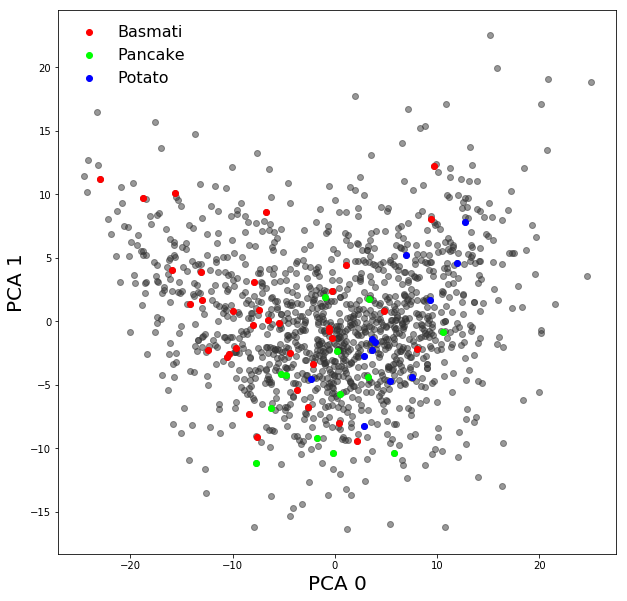

Basmati 35 46
Pancake 13 17
Potato 12 14


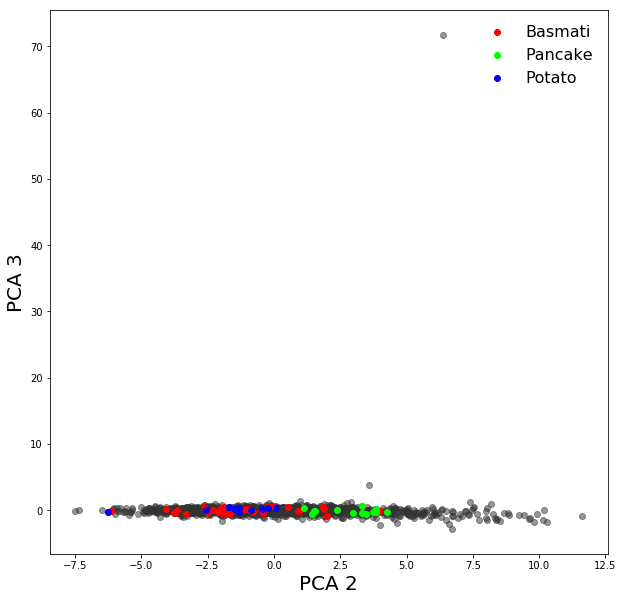

Basmati 35 46
Pancake 13 17
Potato 12 14


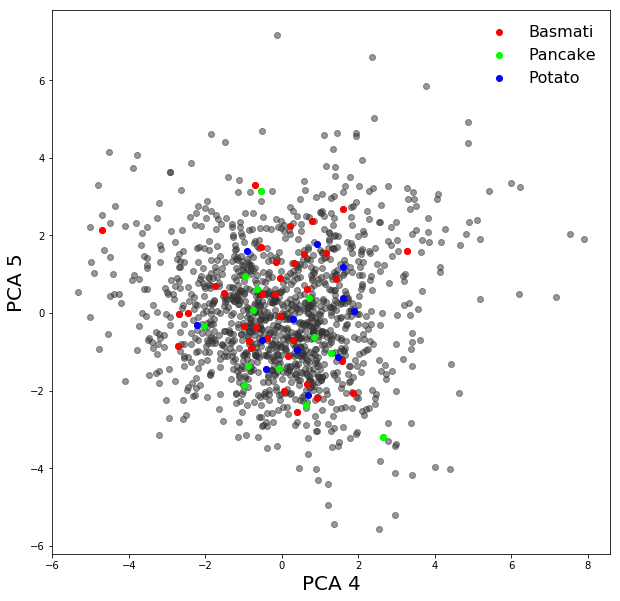

In [36]:
for axis in [[0, 1], [2, 3], [4, 5]]:
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_vecs_pca[:, axis[0]], latent_vecs_pca[:, axis[1]], alpha=.5, c=".2")

    nuno_basket_ids = []
    nuno_basket_labels = []
    for i_bt, bt in enumerate(cell_type_exs.keys()):
        m = np.in1d(basket_ids, cell_type_exs[bt])

        print(bt, np.sum(m), len(cell_type_exs[bt]))
        c = [0, 0, 0]

        if i_bt > 2:
            c[i_bt % 3] = 1
            c[(i_bt + 1) % 3] = 1
        else:
            c[i_bt] = 1

        plt.scatter(latent_vecs_pca[m, axis[0]], 
                    latent_vecs_pca[m, axis[1]], 
                    label=bt, c=c)

        nuno_basket_ids.extend(np.where(m)[0])
        nuno_basket_labels.extend([i_bt] * np.sum(m))

    plt.xlabel("PCA %d" % axis[0], fontsize=20)
    plt.ylabel("PCA %d" % axis[1], fontsize=20)

    plt.legend(fontsize=16, frameon=False)
    plt.show()

    nuno_basket_ids = np.array(nuno_basket_ids)
    nuno_basket_labels = np.array(nuno_basket_labels)